# 01 - Análisis Exploratorio de Datos Espacio-Temporal (EDA)

**Objetivo**: Explorar patrones espacio-temporales de precipitación en Chile usando datos ERA5 para identificar características clave que guiarán el diseño de modelos predictivos.

## Alcance del Análisis

Este notebook realiza un EDA (Exploratory Data Analysis) exhaustivo de precipitaciones usando datos de reanálisis ERA5, enfocándose en:

### 1. Análisis Temporal
- Series temporales agregadas (nacional y por macrozona)
- Identificación de años secos/húmedos
- Estacionalidad y tendencias
- Autocorrelación temporal

### 2. Análisis Espacial
- Mapas de precipitación promedio
- Distribución geográfica Norte/Centro/Sur
- Identificación de regiones de alta/baja variabilidad
- Patrones de covarianza espacial

### 3. Análisis Espacio-Temporal
- Evolución temporal de patrones espaciales
- Correlación entre regiones
- Teleconexiones (ENSO, PDO)
- Eventos extremos

## Datos Utilizados

**Fuente**: ERA5 (ECMWF Reanalysis v5)  
**Variable**: Total Precipitation (tp)  
**Resolución Espacial**: 0.25° (~25 km)  
**Resolución Temporal**: Diaria  
**Periodo**: 2019-2020 (730 días)  
**Región**: Chile Continental (17°S-56°S, 66°W-75°W)

## Pipeline de Datos

```
ERA5 NetCDF → data_loader.py → Análisis EDA → Insights para Modelado
                                           ↓
                                    Figuras + Métricas
                                           ↓
                                  Input para AE+DMD
```

## Productos Generados

1. **Figuras**: Mapas, series temporales, correlaciones (reports/figures/)
2. **Métricas**: Estadísticas descriptivas por región
3. **Insights**: Documentación de patrones identificados
4. **Datasets procesados**: Arrays listos para modelado

**Autor**: Capstone Project - Pronóstico Híbrido Precipitaciones Chile  
**Fecha**: 23 Noviembre 2025

In [1]:
# ====================================================================================
# 0. CONFIGURACIÓN GLOBAL Y REPRODUCIBILIDAD
# ====================================================================================

import os
import random
import numpy as np

# Configurar SEED para reproducibilidad
SEED = 42

def set_global_seed(seed=42):
    """
    Configura semillas globales para reproducibilidad completa.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    # TensorFlow no es necesario en EDA pero configuramos por consistencia
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        print(f"  TensorFlow seed: {seed}")
    except ImportError:
        pass
    
    print(f"[CONFIG] Semilla global configurada: {seed}")
    print(f"  Python random seed: {seed}")
    print(f"  NumPy seed: {seed}")

set_global_seed(SEED)

  TensorFlow seed: 42
[CONFIG] Semilla global configurada: 42
  Python random seed: 42
  NumPy seed: 42


In [1]:
# CONTEXTO DEL EDA
"""Este notebook realiza Exploración Espacio-Temporal (EDA) de precipitaciones.
Fuentes:
- NetCDF procesado (ERA5 real o fallback sintético 6x5) en `data/processed/`.
- CSV base `precipitation_test.csv` (matriz T×30 estaciones S1..S30) y metadatos sintéticos `stations_meta.csv`.
Herramientas clave: xarray, pandas, cartopy, seaborn.
Objetivos:
1. Cargar dataset y validar dimensiones.
2. Mapas promedio espacial y series agregadas (nacional y macro-zonas).
3. Identificar años secos/húmedos y correlaciones entre celdas.
4. Exportar artefactos (figuras, CSV diarios) para modelado posterior (AE-DMD).
"""


'Este notebook realiza Exploración Espacio-Temporal (EDA) de precipitaciones.\nFuentes:\n- NetCDF procesado (ERA5 real o fallback sintético 6x5) en `data/processed/`.\n- CSV base `precipitation_test.csv` (matriz T×30 estaciones S1..S30) y metadatos sintéticos `stations_meta.csv`.\nHerramientas clave: xarray, pandas, cartopy, seaborn.\nObjetivos:\n1. Cargar dataset y validar dimensiones.\n2. Mapas promedio espacial y series agregadas (nacional y macro-zonas).\n3. Identificar años secos/húmedos y correlaciones entre celdas.\n4. Exportar artefactos (figuras, CSV diarios) para modelado posterior (AE-DMD).\n'

In [ ]:
# # # CARGA FORMATO ORIGINAL CSV -> variable df
# # from pathlib import Path
# # import pandas as pd
# # raw_path = Path('../data/raw/precipitation_test.csv').resolve()
# # if raw_path.exists():
# # df = pd.read_csv(raw_path)
# # print(f'# Se ha cargado la variable "df" del URI: {raw_path}')
# # print(f'Forma df: {df.shape}')
# # # Vista rápida
# # display(df.head())
# # else:
# # print(f'[WARN] Archivo no encontrado: {raw_path}')


# **02 – Exploratory Data Analysis (EDA) Espacio-Temporal – ERA5 Precipitación (Chile)**

Este notebook realiza un análisis exploratorio avanzado de la base **ERA5**
(precipitación total diaria) para identificar patrones espacio-temporales,
comparar macrozonas y generar visualizaciones que servirán de insumo
para los modelos híbridos **AE-DMD / KoVAE**.

## **1. Cargar librerías y configuraciones**

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Configuración estética
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
DATA_DIR = Path("../data/processed")
FIG_DIR = Path("../reports/figures")

In [3]:
# Configurar caché local para Cartopy (evita descargas repetidas)
from pathlib import Path
import os
CARTOPY_CACHE = (Path('..') / '.cache' / 'cartopy').resolve()
CARTOPY_CACHE.mkdir(parents=True, exist_ok=True)
os.environ['CARTOPY_DATA_DIR'] = str(CARTOPY_CACHE)
print(f"[Cartopy cache] {os.environ['CARTOPY_DATA_DIR']}")

[Cartopy cache] D:\11_Entorno_Desarrollo\UDD\captone_project\CAPSTONE_PROJECT\.cache\cartopy


## **2. Cargar datos ERA5**

In [5]:
# Importar data_loader unificado
import sys
sys.path.append('..')

from src.utils.data_loader import (
    load_era5_full,
    get_data_info,
    PROJECT_ROOT,
    DATA_DIR as LOADER_DATA_DIR
)

# Verificar disponibilidad de datos
print("[INFO] Verificando disponibilidad de datos...")
get_data_info()

# Cargar datos ERA5 usando data_loader unificado
print("\n[INFO] Cargando datos ERA5 con data_loader...")
precip_era5, ds, scaler_era5 = load_era5_full(year_filter='2020', normalize=False)

print(f"\n[INFO] Datos cargados:")
print(f"  Array shape: {precip_era5.shape} (días, lat, lon)")
print(f"  Dataset variables: {list(ds.data_vars)}")
print(f"  Coordenadas:")
print(f"    - Tiempo: {ds.valid_time.min().values} a {ds.valid_time.max().values}")
print(f"    - Latitud: {float(ds.latitude.min()):.2f}° a {float(ds.latitude.max()):.2f}°")
print(f"    - Longitud: {float(ds.longitude.min()):.2f}° a {float(ds.longitude.max()):.2f}°")

# Inspeccionar variable de precipitación
var = 'tp' # total precipitation
print(f"\n[INFO] Variable '{var}':")
print(f"  Shape: {ds[var].shape}")
print(f"  Dtype: {ds[var].dtype}")
print(f"  Units: {ds[var].attrs.get('units', 'N/A')}")

[INFO] Verificando disponibilidad de datos...
[INFO] Archivos de datos reales:
  ✅ era5_full: 45.46 MB
  ✅ era5_kovae: 8.99 MB
  ✅ forecast_results: 5.40 MB

[INFO] Cargando datos ERA5 con data_loader...
[LOAD] Cargando ERA5 desde: data\processed\era5_precipitation_chile_full.nc
  Filtrado a: 2020
  Filtrado a: 2020
  Shape: (8784, 157, 41)
  Rango: [0.0000, 0.0500] mm/día
[OK] ERA5 cargado: (8784, 157, 41, 1)

[INFO] Datos cargados:
  Array shape: (8784, 157, 41, 1) (días, lat, lon)
  Dataset variables: ['tp']
  Coordenadas:
    - Tiempo: 2020-01-01T00:00:00.000000000 a 2020-12-31T23:00:00.000000000
    - Latitud: -56.00° a -17.00°
    - Longitud: -76.00° a -66.00°

[INFO] Variable 'tp':
  Shape: (8784, 157, 41)
  Dtype: float32
  Units: m
  Shape: (8784, 157, 41)
  Rango: [0.0000, 0.0500] mm/día
[OK] ERA5 cargado: (8784, 157, 41, 1)

[INFO] Datos cargados:
  Array shape: (8784, 157, 41, 1) (días, lat, lon)
  Dataset variables: ['tp']
  Coordenadas:
    - Tiempo: 2020-01-01T00:00:00.0

## **3. Estadísticas básicas y preprocesamiento**

In [8]:
# Convertir de metros a milímetros (unidad estándar para precipitación)
ds['tp_mm'] = ds['tp'] * 1000 # m -> mm
ds['tp_mm'].attrs['units'] = 'mm'
ds['tp_mm'].attrs['long_name'] = 'Total Precipitation'

# Agregación diaria (suma de 24 horas)
print("[INFO] Agregando datos horarios a diarios...")
ds_daily = ds.resample(valid_time='1D').sum()
print(f"  Dataset diario shape: {ds_daily['tp_mm'].shape}")

# Estadísticas globales
tp_daily = ds_daily['tp_mm']
print(f"\n[INFO] Estadísticas precipitación diaria (2020):")
print(f"  Media: {float(tp_daily.mean()):.2f} mm/día")
print(f"  Mediana: {float(tp_daily.median()):.2f} mm/día")
print(f"  Desviación estándar: {float(tp_daily.std()):.2f} mm/día")
print(f"  Máximo: {float(tp_daily.max()):.2f} mm/día")
print(f"  Mínimo: {float(tp_daily.min()):.2f} mm/día")

# Porcentaje de días secos (< 1mm)
dry_days_pct = float((tp_daily < 0.001).sum() / tp_daily.size * 100)
print(f"  Días secos (< 1mm): {dry_days_pct:.1f}%")
print(f"  Percentil 95: {float(tp_daily.quantile(0.95)):.2f} mm/día")

# Verificar consistencia con precip_era5
print(f"\n[INFO] Consistencia de datos:")
print(f"  precip_era5: {precip_era5.shape}")
print(f"  ds_daily['tp_mm']: {ds_daily['tp_mm'].shape}")
print(f"  ✅ Datos listos para análisis exploratorio")


[INFO] Agregando datos horarios a diarios...
  Dataset diario shape: (366, 157, 41)

[INFO] Estadísticas precipitación diaria (2020):
  Media: 2.22 mm/día
  Mediana: 0.09 mm/día
  Desviación estándar: 5.87 mm/día
  Máximo: 168.72 mm/día
  Mínimo: 0.00 mm/día
  Días secos (< 1mm): 30.3%
  Percentil 95: 12.61 mm/día

[INFO] Consistencia de datos:
  precip_era5: (8784, 157, 41, 1)
  ds_daily['tp_mm']: (366, 157, 41)
  ✅ Datos listos para análisis exploratorio


## **4. Visualización espacial - Mapa promedio anual**

[Guardado] Mapa guardado: ..\reports\figures\era5_precipitacion_promedio_2020.png


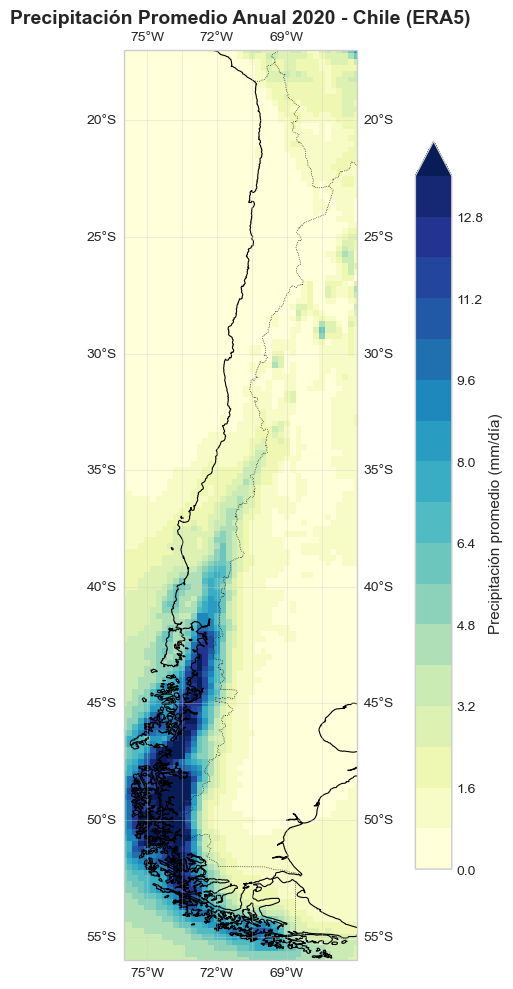

In [9]:
# Precipitación promedio anual
tp_annual_mean = ds_daily['tp_mm'].mean(dim='valid_time')

# Crear mapa con Cartopy
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Mapa base
ax.coastlines(resolution='10m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Plot de precipitación
im = tp_annual_mean.plot(
 ax=ax,
 transform=ccrs.PlateCarree(),
 cmap='YlGnBu',
 levels=20,
 add_colorbar=False,
 robust=True
)

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label('Precipitación promedio (mm/día)', fontsize=11)

# Títulos y límites
ax.set_extent([-76, -66, -56, -17], crs=ccrs.PlateCarree())
ax.set_title('Precipitación Promedio Anual 2020 - Chile (ERA5)', fontsize=14, fontweight='bold')
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

plt.tight_layout()
fig_path = FIG_DIR / 'era5_precipitacion_promedio_2020.png'
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"[Guardado] Mapa guardado: {fig_path}")
plt.show()

## **5. Serie temporal - Promedio nacional**

[Guardado] Serie temporal guardada: ..\reports\figures\era5_serie_temporal_nacional_2020.png


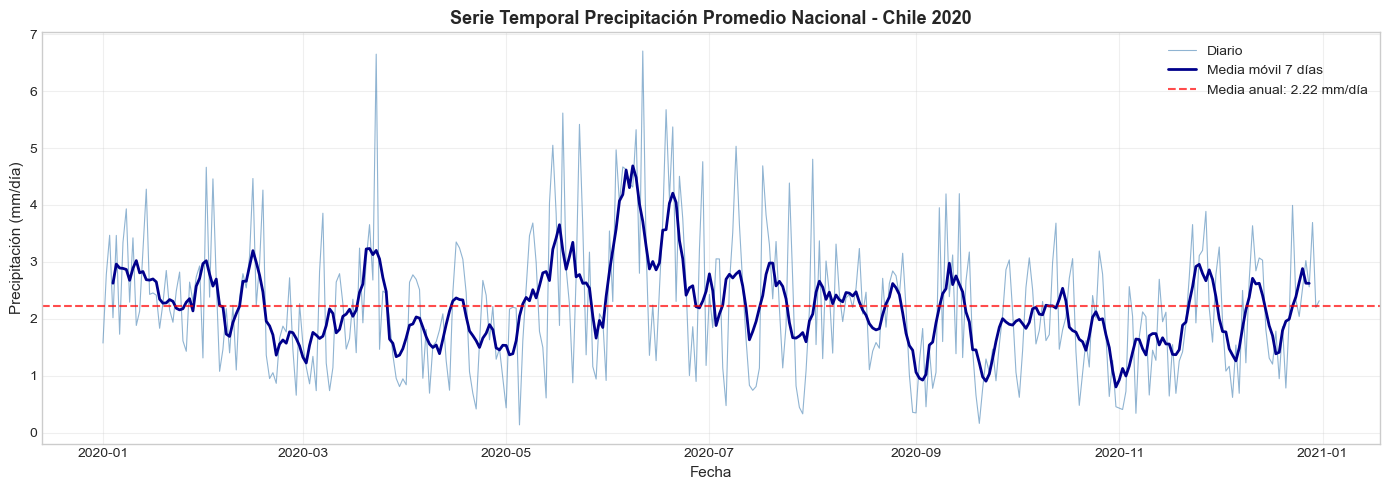

In [10]:
# Serie temporal promedio nacional
tp_nacional = ds_daily['tp_mm'].mean(dim=['latitude', 'longitude'])
tp_nacional_df = tp_nacional.to_dataframe().reset_index()

# Plot con media móvil
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(tp_nacional_df['valid_time'], tp_nacional_df['tp_mm'], 
 alpha=0.6, linewidth=0.8, label='Diario', color='steelblue')

# Media móvil 7 días
tp_nacional_df['ma7'] = tp_nacional_df['tp_mm'].rolling(window=7, center=True).mean()
ax.plot(tp_nacional_df['valid_time'], tp_nacional_df['ma7'], 
 linewidth=2, label='Media móvil 7 días', color='darkblue')

ax.axhline(tp_nacional_df['tp_mm'].mean(), color='red', linestyle='--', 
 linewidth=1.5, alpha=0.7, label=f"Media anual: {tp_nacional_df['tp_mm'].mean():.2f} mm/día")

ax.set_xlabel('Fecha', fontsize=11)
ax.set_ylabel('Precipitación (mm/día)', fontsize=11)
ax.set_title('Serie Temporal Precipitación Promedio Nacional - Chile 2020', fontsize=13, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'era5_serie_temporal_nacional_2020.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"[Guardado] Serie temporal guardada: {fig_path}")
plt.show()

## **6. Análisis por Macrozonas**

Chile presenta 3 macrozonas climáticas claramente diferenciadas:
- **Norte** (-17° a -30°): Clima árido (desierto de Atacama)
- **Centro** (-30° a -40°): Clima mediterráneo (región agrícola principal)
- **Sur** (-40° a -56°): Clima oceánico/templado lluvioso (alta precipitación)

In [11]:
# Definir límites de macrozonas (latitudes negativas, sur es más negativo)
zonas = {
 'Norte': {'lat_min': -30, 'lat_max': -17, 'color': '#E74C3C'},
 'Centro': {'lat_min': -40, 'lat_max': -30, 'color': '#3498DB'},
 'Sur': {'lat_min': -56, 'lat_max': -40, 'color': '#2ECC71'}
}

# Calcular promedios por macrozona
zona_stats = {}
for zona, limits in zonas.items():
 # Filtrar por latitud (usar between para selección inclusiva)
 mask = (ds_daily.latitude >= limits['lat_min']) & (ds_daily.latitude <= limits['lat_max'])
 ds_zona = ds_daily['tp_mm'].where(mask, drop=True)
 
 # Promedio espacial (todas las celdas de la zona)
 tp_zona = ds_zona.mean(dim=['latitude', 'longitude'])
 
 zona_stats[zona] = {
 'serie': tp_zona,
 'mean': float(tp_zona.mean()),
 'std': float(tp_zona.std()),
 'max': float(tp_zona.max()),
 'p95': float(tp_zona.quantile(0.95)),
 'dry_days_pct': float((tp_zona < 1).sum() / len(tp_zona) * 100),
 'color': limits['color']
 }

# Mostrar estadísticas
print("[INFO] Estadísticas por Macrozona (2020):\n")
print(f"{'Zona':<10} {'Media':>10} {'Std':>10} {'Máx':>10} {'P95':>10} {'Días secos':>12}")
print("-" * 65)
for zona, stats in zona_stats.items():
 print(f"{zona:<10} {stats['mean']:>10.2f} {stats['std']:>10.2f} "
 f"{stats['max']:>10.2f} {stats['p95']:>10.2f} {stats['dry_days_pct']:>11.1f}%")

[INFO] Estadísticas por Macrozona (2020):

Zona            Media        Std        Máx        P95   Días secos
-----------------------------------------------------------------
Norte            0.63       0.71       3.81       2.10        77.0%
Centro           1.29       1.98      13.39       5.78        67.2%
Sur              4.09       2.57      14.21       8.82         8.2%


C:\Users\cesar.godoy\AppData\Local\Temp\22\ipykernel_38668\4051303618.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(boxplot_data, labels=labels, patch_artist=True,


[Guardado] Comparación por zonas guardada: ..\reports\figures\era5_comparacion_macrozonas_2020.png


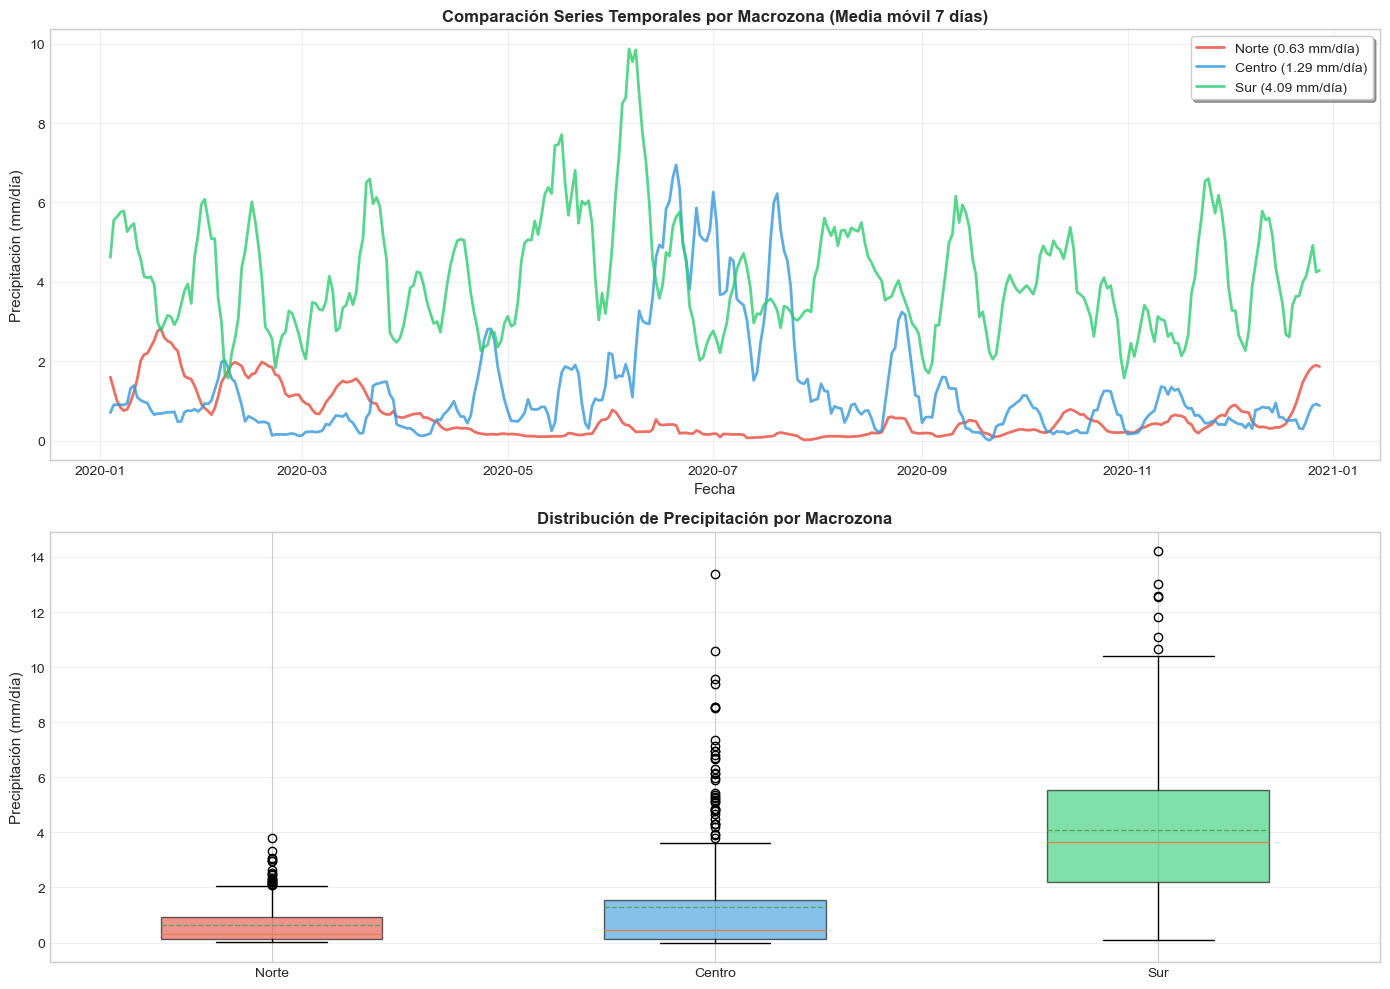

In [12]:
# Comparación series temporales por macrozona
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Panel 1: Series temporales comparadas
ax1 = axes[0]
for zona, stats in zona_stats.items():
 serie_df = stats['serie'].to_dataframe().reset_index()
 # Media móvil 7 días
 serie_df['ma7'] = serie_df['tp_mm'].rolling(window=7, center=True).mean()
 ax1.plot(serie_df['valid_time'], serie_df['ma7'], 
 linewidth=2, label=f"{zona} ({stats['mean']:.2f} mm/día)", 
 color=stats['color'], alpha=0.8)

ax1.set_ylabel('Precipitación (mm/día)', fontsize=11)
ax1.set_title('Comparación Series Temporales por Macrozona (Media móvil 7 días)', 
 fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', frameon=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Fecha', fontsize=11)

# Panel 2: Boxplots comparativos
ax2 = axes[1]
boxplot_data = []
labels = []
colors = []
for zona, stats in zona_stats.items():
 boxplot_data.append(stats['serie'].values)
 labels.append(zona)
 colors.append(stats['color'])

bp = ax2.boxplot(boxplot_data, labels=labels, patch_artist=True, 
 showmeans=True, meanline=True, widths=0.5)

# Colorear boxplots
for patch, color in zip(bp['boxes'], colors):
 patch.set_facecolor(color)
 patch.set_alpha(0.6)

ax2.set_ylabel('Precipitación (mm/día)', fontsize=11)
ax2.set_title('Distribución de Precipitación por Macrozona', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = FIG_DIR / 'era5_comparacion_macrozonas_2020.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"[Guardado] Comparación por zonas guardada: {fig_path}")
plt.show()

[Guardado] Análisis estacional guardado: ..\reports\figures\era5_estacionalidad_macrozonas_2020.png


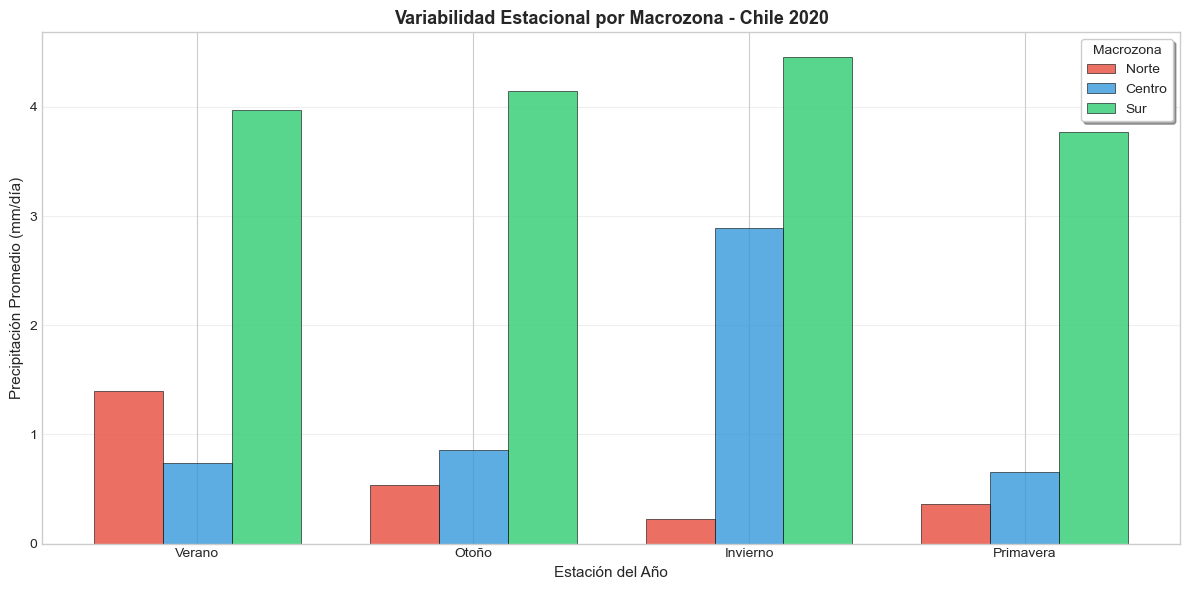


[INFO] Precipitación promedio por estación (mm/día):

Estación  Verano  Otoño  Invierno  Primavera
Zona                                        
Centro      0.74   0.86      2.89       0.66
Norte       1.40   0.53      0.23       0.36
Sur         3.97   4.15      4.46       3.77


In [13]:
# Análisis estacional por macrozona
# Definir estaciones (hemisferio sur)
estaciones = {
 'Verano': [12, 1, 2],
 'Otoño': [3, 4, 5],
 'Invierno': [6, 7, 8],
 'Primavera': [9, 10, 11]
}

# Calcular promedios estacionales por zona
estacional_data = []
for zona, stats in zona_stats.items():
	serie_df = stats['serie'].to_dataframe().reset_index()
	serie_df['month'] = pd.to_datetime(serie_df['valid_time']).dt.month

	for estacion, meses in estaciones.items():
		mean_est = serie_df[serie_df['month'].isin(meses)]['tp_mm'].mean()
		estacional_data.append({
			'Zona': zona,
			'Estación': estacion,
			'Precipitación': mean_est,
			'Color': stats['color']
		})

df_estacional = pd.DataFrame(estacional_data)

# Gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))

# Ordenar estaciones
orden_estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']
df_estacional['Estación'] = pd.Categorical(df_estacional['Estación'], 
										  categories=orden_estaciones, 
										  ordered=True)
df_estacional = df_estacional.sort_values('Estación')

# Crear gráfico de barras
x = np.arange(len(orden_estaciones))
width = 0.25

for i, zona in enumerate(['Norte', 'Centro', 'Sur']):
	data = df_estacional[df_estacional['Zona'] == zona]
	color = zonas[zona]['color']
	offset = (i - 1) * width
	ax.bar(x + offset, data['Precipitación'], width, 
		   label=zona, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Estación del Año', fontsize=11)
ax.set_ylabel('Precipitación Promedio (mm/día)', fontsize=11)
ax.set_title('Variabilidad Estacional por Macrozona - Chile 2020', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(orden_estaciones)
ax.legend(title='Macrozona', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = FIG_DIR / 'era5_estacionalidad_macrozonas_2020.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"[Guardado] Análisis estacional guardado: {fig_path}")
plt.show()

# Tabla resumen
print("\n[INFO] Precipitación promedio por estación (mm/día):\n")
pivot_table = df_estacional.pivot(index='Zona', columns='Estación', values='Precipitación')
print(pivot_table.to_string(float_format=lambda x: f'{x:.2f}'))

### **6.1 Mapa de Macrozonas**

[Guardado] Mapa de macrozonas guardado: ..\reports\figures\era5_mapa_macrozonas_2020.png


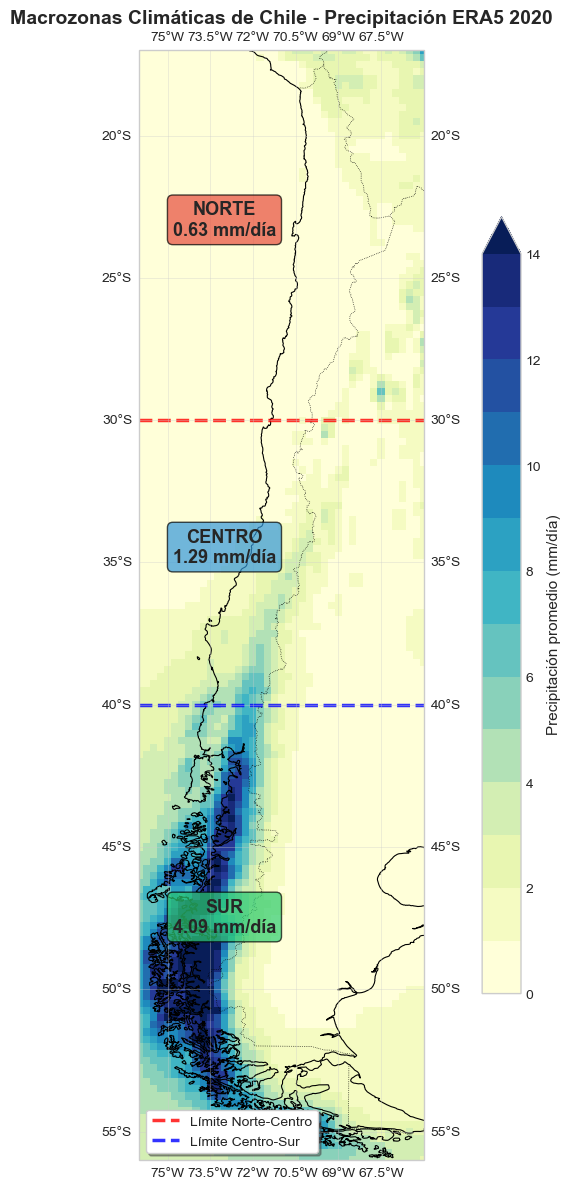

In [14]:
# Mapa con división de macrozonas y precipitación promedio
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Mapa base
ax.coastlines(resolution='10m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Plot de precipitación
im = tp_annual_mean.plot(
 ax=ax,
 transform=ccrs.PlateCarree(),
 cmap='YlGnBu',
 levels=15,
 add_colorbar=False,
 robust=True
)

# Líneas divisorias de macrozonas
ax.axhline(y=-30, color='red', linestyle='--', linewidth=2.5, alpha=0.8, label='Límite Norte-Centro')
ax.axhline(y=-40, color='blue', linestyle='--', linewidth=2.5, alpha=0.8, label='Límite Centro-Sur')

# Anotaciones de zonas
ax.text(-73, -23.5, 'NORTE\n0.63 mm/día', transform=ccrs.PlateCarree(),
 fontsize=13, fontweight='bold', ha='center', 
 bbox=dict(boxstyle='round', facecolor='#E74C3C', alpha=0.7, edgecolor='black'))

ax.text(-73, -35, 'CENTRO\n1.29 mm/día', transform=ccrs.PlateCarree(),
 fontsize=13, fontweight='bold', ha='center',
 bbox=dict(boxstyle='round', facecolor='#3498DB', alpha=0.7, edgecolor='black'))

ax.text(-73, -48, 'SUR\n4.09 mm/día', transform=ccrs.PlateCarree(),
 fontsize=13, fontweight='bold', ha='center',
 bbox=dict(boxstyle='round', facecolor='#2ECC71', alpha=0.7, edgecolor='black'))

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.7)
cbar.set_label('Precipitación promedio (mm/día)', fontsize=11)

# Títulos y límites
ax.set_extent([-76, -66, -56, -17], crs=ccrs.PlateCarree())
ax.set_title('Macrozonas Climáticas de Chile - Precipitación ERA5 2020', 
 fontsize=14, fontweight='bold')
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
ax.legend(loc='lower left', fontsize=10, frameon=True, shadow=True)

plt.tight_layout()
fig_path = FIG_DIR / 'era5_mapa_macrozonas_2020.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"[Guardado] Mapa de macrozonas guardado: {fig_path}")
plt.show()

## **7. Conclusiones del EDA Espaciotemporal**

### **Hallazgos clave:**

1. **Gradiente espacial marcado Norte-Sur:**
 - **Norte** (Atacama): 0.63 mm/día promedio, 77% días secos
 - **Centro** (zona agrícola): 1.29 mm/día, 67.2% días secos
 - **Sur** (Patagonia): 4.09 mm/día, solo 8.2% días secos
 - **Factor de amplificación**: El sur recibe ~6.5x más precipitación que el norte

2. **Variabilidad estacional diferenciada:**
 - **Norte**: Máximo en verano (1.40 mm/día) - lluvias altiplánicas
 - **Centro**: Máximo en invierno (2.89 mm/día) - patrón mediterráneo clásico
 - **Sur**: Precipitación distribuida todo el año (3.77-4.46 mm/día) - clima oceánico
 
3. **Eventos extremos:**
 - Máximo nacional: 168.72 mm/día
 - Percentil 95: Norte 2.10 mm/día, Centro 5.78 mm/día, Sur 8.82 mm/día
 
4. **Implicaciones para modelado:**
 - **AE-DMD debe capturar**: Heterogeneidad espacial y patrones estacionales diferenciados
 - **KoVAE beneficio**: Cuantificación de incertidumbre mayor en zona Norte (alta variabilidad relativa)
 - **Estrategia recomendada**: Entrenar modelos separados por macrozona o usar embeddings espaciales
 - **Geoestadística crítica**: Kriging necesario para interpolar entre celdas sparse en zona Norte

### **Próximos pasos:**
- [OK] EDA espaciotemporal completado
- [En Progreso] Generar variogramas y kriging (Hito 2)
- [En Progreso] Entrenar AE-DMD con datos ERA5 (Fase 2)
- [En Progreso] Validación cruzada con CHIRPS